# <div style="font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:white; font-size:200%; text-align:center;padding:3.0px; background: #6A1B9A; border-bottom: 8px solid #9C27B0">Ichimoku Cloud EDA</div>
#### <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:white; font-size:150%; text-align:left;padding:3.0px; background: #6A1B9A; border-bottom: 8px solid #9C27B0" >TABLE OF CONTENTS<br><div>
* [IMPORTS](#1)
* [LOAD DATA](#3)
* [INTRODUCTION](#3)
    * [DATASET COLUMNS](#3.1)
* [PREPROCESSING](#4)
* [EDA AND VISUALS](#5) 



<a id="1"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:white; font-size:120%; text-align:left;padding:3.0px; background: #6A1B9A; border-bottom: 8px solid #9C27B0" > IMPORTS<br><div> 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import psycopg2
import seaborn as sns
from sklearn.manifold import TSNE
from dotenv import load_dotenv

from tools.data_helper import process_data, evaluate_for_stationary_series, filter_data
from tools.machine_learning_helper import (asymmetric_mean_squared_error, modified_mean_squared_log_error, 
                                           asymmetric_squared_error_objective,
                                           train_and_test_pipelines, train_test_split_timeseries)
from tools.model_evaluation_helper import (get_accuracy_fig, get_actual_vs_threshold_prob_fig, 
                                           get_actual_vs_pred_prob_fig, get_feature_names, analyze_signal_for_report,
                                           get_med_actual_if_pred_above_thresh_fig)

In [32]:
# Load environment variables from .env file
load_dotenv()

sns.set({"axes.facecolor"       : "#ffffff",
         "figure.facecolor"     : "#ffffff",
         "axes.edgecolor"       : "#000000",
         "grid.color"           : "#ffffff",
         "font.family"          : ['Cambria'],
         "axes.labelcolor"      : "#000000",
         "xtick.color"          : "#000000",
         "ytick.color"          : "#000000",
         "grid.linewidth"       : 0.75,  
         "grid.linestyle"       : "--",
         "axes.titlecolor"      : '#0099e6',
         'axes.titlesize'       : 8.5,
         'axes.labelweight'     : "bold",
         'legend.fontsize'      : 7.0,
         'legend.title_fontsize': 7.0,
         'font.size'            : 12,
         'xtick.labelsize'      : 12,
         'ytick.labelsize'      : 12,        
        });

<a id="2"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:white; font-size:120%; text-align:left;padding:3.0px; background: #6A1B9A; border-bottom: 8px solid #9C27B0" > LOAD DATA<br><div> 

In [13]:
# Database connection parameters
db_params = {
    'dbname': 'stock',
    'user': os.environ["POSTGRES_USER"],
    'password': os.environ["POSTGRES_PASSWORD"],
    'host': 'localhost',
    'port': '5432'
}

days_into_future = 25
max_target = f'max_close_next_{days_into_future}'
min_target = f'max_close_next_{days_into_future}'
date = '2021-01-01'
# Using the with statement for managing the connection
with psycopg2.connect(**db_params) as conn:
    with conn.cursor() as cur:
        
        query = f"""
        WITH adjusted_quotes AS (
            SELECT
                sd.id,
                sd.date,
                sd.open,
                sd.high,
                sd.low,
                sd.close,
                sd.volume,
                s.ticker_id,
                MAX(sd.close) OVER (PARTITION BY s.ticker_id ORDER BY sd.date ROWS BETWEEN 1 FOLLOWING AND 
                {days_into_future} FOLLOWING) / sd.close - 1 AS {max_target}
            FROM
                stock_quotes_daily_adj sd
            INNER JOIN
                stock_quotes_daily s ON sd.id = s.id
            INNER JOIN
                tickers t ON t.ticker_id = s.ticker_id
            WHERE 
                t.s_and_p_500 = true AND sd.date >= DATE '{date}' - INTERVAL '{2 * days_into_future} days'
        )
        SELECT *
        FROM adjusted_quotes as adj
        LEFT JOIN stock_quotes_daily_adj_ti as ti        
        USING (id)
        WHERE date >= '{date}';
        """
        
        cur.execute(query)
        rows = cur.fetchall()
        colnames = [desc[0] for desc in cur.description]
    
        df = pd.DataFrame(rows, columns=colnames)
df

id        date   open    high     low  close       volume  \
0       136107  2021-01-04  30.46  30.570  29.750  30.03   51483911.0   
1       136101  2021-01-12  33.42  33.970  33.200  33.66   67870790.0   
2       136082  2021-02-09  32.97  33.020  32.585  32.95   35786387.0   
3       136055  2021-03-19  38.29  38.920  37.530  38.53  106252691.0   
4       136041  2021-04-09  39.91  40.180  39.510  39.99   45872878.0   
...        ...         ...    ...     ...     ...    ...          ...   
369150  613747  2023-10-31  77.56  78.350  77.090  78.11    6776099.0   
369151  613746  2023-11-01  78.30  79.290  77.720  79.05    3770129.0   
369152  613744  2023-11-03  81.97  82.715  81.220  82.23    2707150.0   
369153  613737  2023-11-14  81.50  82.160  81.065  81.82    2680621.0   
369154  613736  2023-11-15  81.72  82.090  80.410  80.42    2900059.0   

        ticker_id  max_close_next_25   sma_20  ...     rsi_14     mfi_14  \
0             184           0.131868  29.3145  ...  61.605976  69.659031   
1             184           0.022282  30.3515  ...  77.598811  72.189487   
2             184           0.151745  31.8965  ...  61.689372  49.212351   
3             184           0.039709  36.7835  ...  68.307616  66.073520   
4             184           0.059265  38.5630  ...  66.107697  59.612108   
...           ...                ...      ...  ...        ...        ...   
369150        148           0.062220  78.4850  ...  51.647183  59.571343   
369151        148           0.049589  78.6340  ...  56.097485  60.685508   
369152        148           0.008999  79.1300  ...  67.221507  62.681608   
369153        148           0.014055  79.5760  ...  62.396917  64.166392   
369154        148           0.031709  79.5795  ...  54.028940  63.260316   

         rmi_14_5  macd_12_26_9  macd_signal_12_26_9  macd_hist_12_26_9  \
0       90.812352      0.680298             0.685954          -0.005656   
1       98.585512      1.260592             0.960655           0.299936   
2       71.307293      0.453803             0.345199           0.108604   
3       98.842763      1.305613             1.256313           0.049300   
4       91.522866      1.080775             1.057961           0.022813   
...           ...           ...                  ...                ...   
369150  34.500971      0.179877             0.495443          -0.315566   
369151  38.973190      0.248938             0.446142          -0.197204   
369152  70.664997      0.755694             0.518909           0.236785   
369153  75.439817      1.013004             0.860654           0.152350   
369154  75.665814      0.919325             0.872388           0.046937   

        ic_conversion_9_26_52  ic_base_9_26_52  ic_span_a_9_26_52  \
0                     29.6500          29.3350           26.85250   
1                     31.8600          31.0550           27.02750   
2                     31.4250          31.9700           29.39375   
3                     37.8889          36.2589           31.73250   
4                     39.0700          38.0450           34.45250   
...                       ...              ...                ...   
369150                78.3340          78.4600           76.10500   
369151                77.6240          78.4600           76.10500   
369152                79.3215          78.8025           76.10500   
369153                80.6975          79.3215           76.26370   
369154                81.4325          79.3215           76.64120   

        ic_span_b_9_26_52  
0                25.97000  
1                26.06500  
2                26.83250  
3                31.23500  
4                32.73500  
...                   ...  
369150           73.71505  
369151           73.71505  
369152           74.17505  
369153           75.20005  
369154           75.49750  

[369155 rows x 22 columns]

<a id="3"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:white; font-size:120%; text-align:left;padding:3.0px; background: #6A1B9A; border-bottom: 8px solid #9C27B0" > INTRODUCTION<br><div> 

<a id="3.1"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #9C27B0; border-bottom: 8px solid #6A1B9A" > DATASET COLUMNS<br><div>

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369155 entries, 0 to 369154
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     369155 non-null  int64  
 1   date                   369155 non-null  object 
 2   open                   369155 non-null  float64
 3   high                   369155 non-null  float64
 4   low                    369155 non-null  float64
 5   close                  369155 non-null  float64
 6   volume                 369155 non-null  float64
 7   ticker_id              369155 non-null  int64  
 8   max_close_next_25      368652 non-null  float64
 9   sma_20                 369075 non-null  float64
 10  sma_50                 368911 non-null  float64
 11  sma_200                368209 non-null  float64
 12  rsi_14                 369099 non-null  float64
 13  mfi_14                 369099 non-null  float64
 14  rmi_14_5               369080 non-nu

<a id="4"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:white; font-size:120%; text-align:left;padding:3.0px; background: #6A1B9A; border-bottom: 8px solid #9C27B0" > PREPROCESSING<br><div> 

In [111]:
df['date'] = pd.to_datetime(df['date'])

# ichimoku cloud features are proportional to a stock's price, so need to scale.
ichimoku_cloud_cols = ['ic_base_9_26_52', 'ic_conversion_9_26_52', 'ic_span_a_9_26_52', 'ic_span_b_9_26_52']
ichimoku_cloud_scaled_cols = []

for col in ichimoku_cloud_cols:
    new_col = col + '_scaled'
    df[new_col] = df[col] / df['close']
    ichimoku_cloud_scaled_cols.append(new_col)
    
# reduce dataset to recent
df_recent = df[df['date'] >= pd.Timestamp(date)].dropna()

<a id="5"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:white; font-size:120%; text-align:left;padding:3.0px; background: #6A1B9A; border-bottom: 8px solid #9C27B0" > EDA AND VISUALS<br><div> 

<a id="5.1"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #9C27B0; border-bottom: 8px solid #6A1B9A" > Correlation and Distribution<br><div>

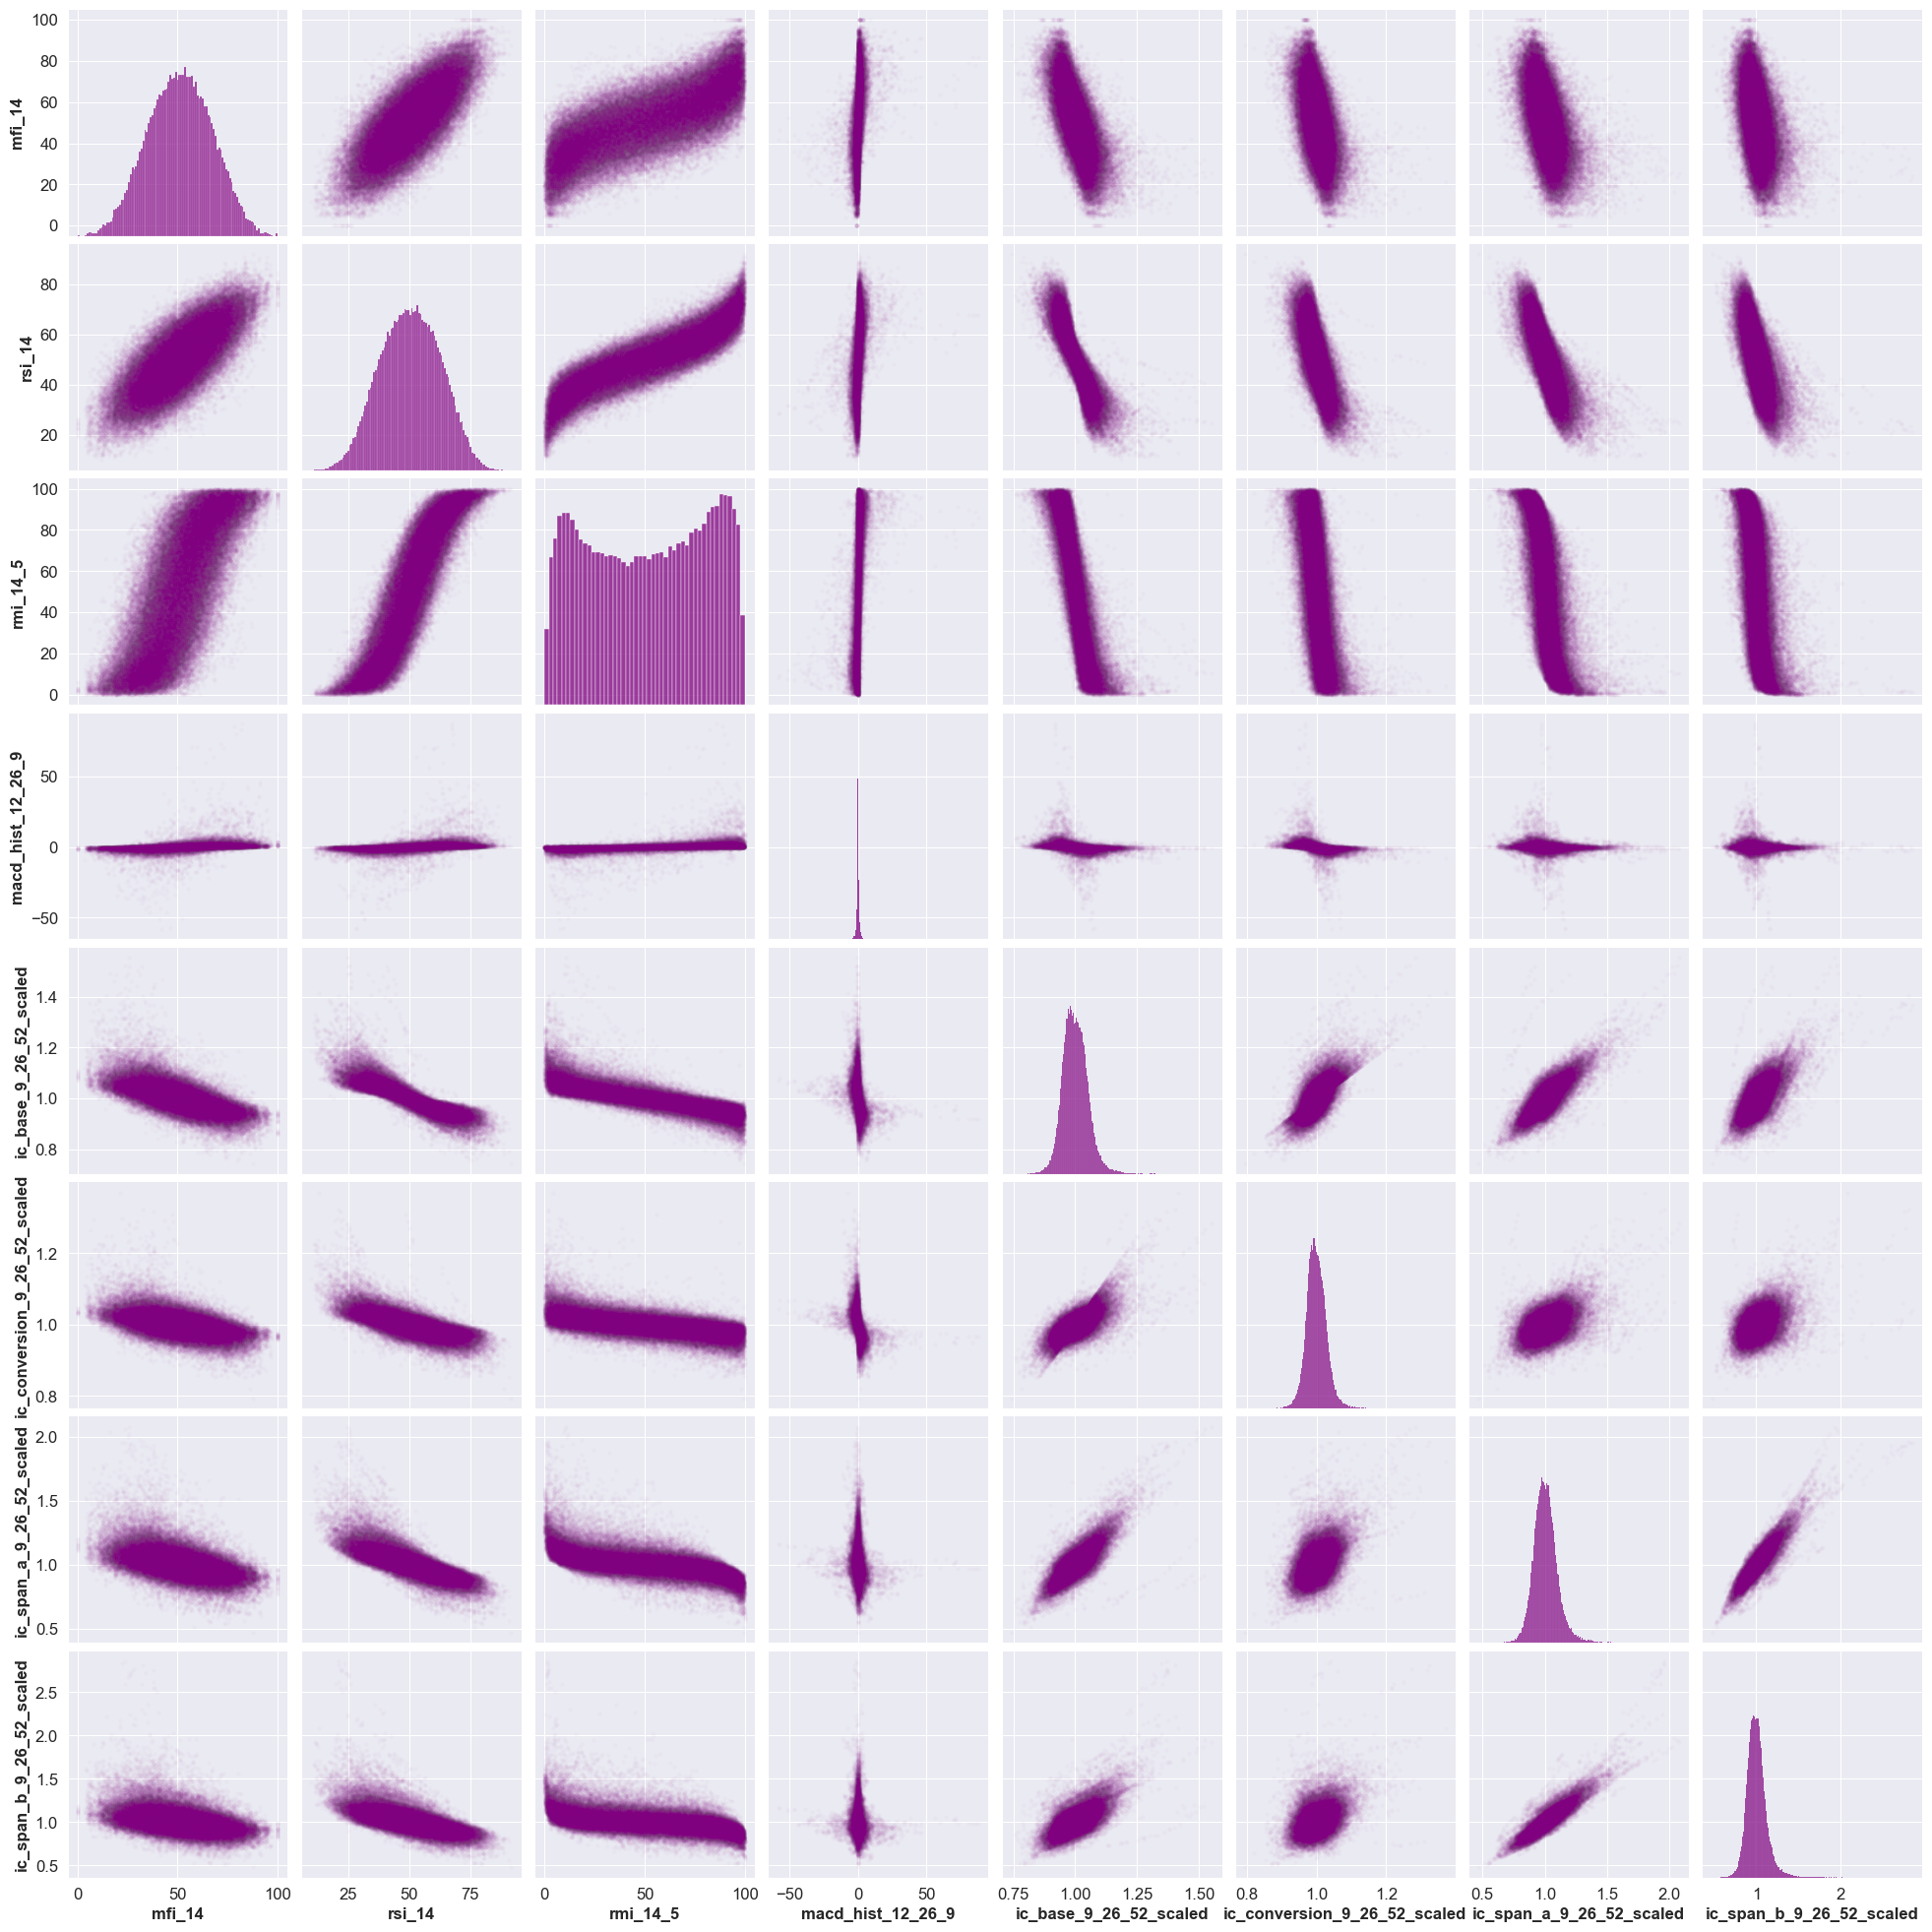

In [6]:

plot_cols = ['mfi_14', 'rsi_14', 'rmi_14_5', 'macd_hist_12_26_9'] + ichimoku_cloud_scaled_cols

sns.set_palette("bright")  # Replace "pastel" with your desired palette

sns.pairplot(df_recent[plot_cols], diag_kind='hist', 
             plot_kws={'alpha': 0.02, 's': 10, 'color': 'purple'},
             diag_kws={'color': 'purple'});


<a id="5.2"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #9C27B0; border-bottom: 8px solid #6A1B9A" > Manifold Learning<br><div>

In [87]:

# tsne_cols = ['mfi_14', 'rsi_14', 'rmi_14_5', 'macd_hist_12_26_9'] + ichimoku_cloud_scaled_cols

n_components = 2  # number of coordinates for the manifold

t_sne = TSNE(
    n_components=n_components,
    perplexity=100,
    init="pca",
    # n_iter=250,
    random_state=0,
    n_jobs=-1
)
S_t_sne = t_sne.fit_transform(df_recent[ichimoku_cloud_scaled_cols])


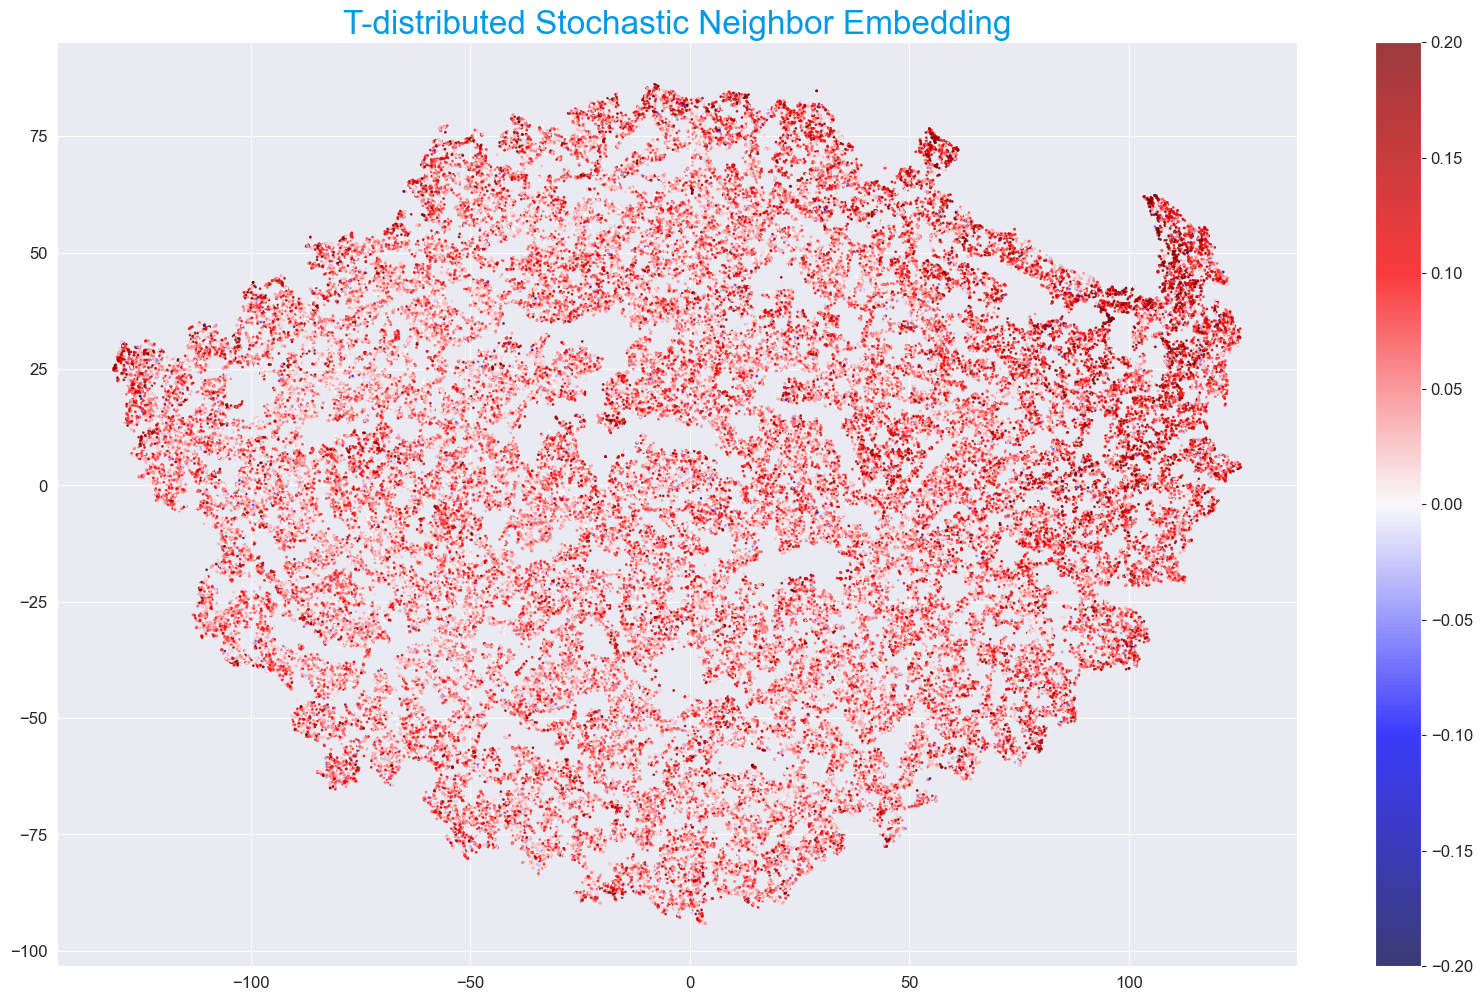

In [110]:
f, ax = plt.subplots(figsize=(20, 12))
points = ax.scatter(x=S_t_sne[:, 0], y=S_t_sne[:, 1], c=df_recent[max_target], alpha=0.75, s=1, cmap="seismic", vmin=-0.2, 
                    vmax=0.2)
ax.set_title("T-distributed Stochastic Neighbor Embedding", fontsize=24);

f.colorbar(points);


In [102]:
tsne_cols = ['mfi_14', 'rsi_14', 'rmi_14_5', 'macd_hist_12_26_9'] + ichimoku_cloud_scaled_cols

n_components = 3  # number of coordinates for the manifold

t_sne = TSNE(
    n_components=n_components,
    perplexity=30,
    init="pca",
    n_iter=250,
    random_state=0,
)
S_t_sne_3 = t_sne.fit_transform(df_recent[tsne_cols])

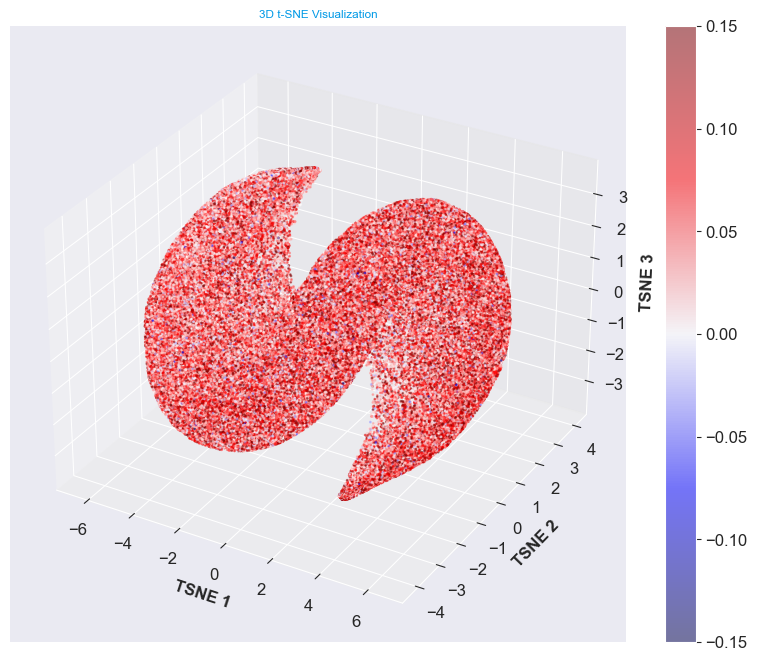

In [108]:
# from mpl_toolkits.mplot3d import Axes3D

# Set up a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D scatter plot
scatter = ax.scatter(S_t_sne_3[:, 0], S_t_sne_3[:, 1], S_t_sne_3[:, 2], 
                     c=df_recent[max_target],  # Color by target
                     cmap='seismic',  
                     alpha=.5, 
                     s=1,
                     vmin=-0.15, 
                     vmax=0.15)                  # Point size

# Add labels and title if needed
ax.set_xlabel('TSNE 1')
ax.set_ylabel('TSNE 2')
ax.set_zlabel('TSNE 3')
ax.set_title('3D t-SNE Visualization')

# Color bar
plt.colorbar(scatter)

# Show the plot
plt.show()


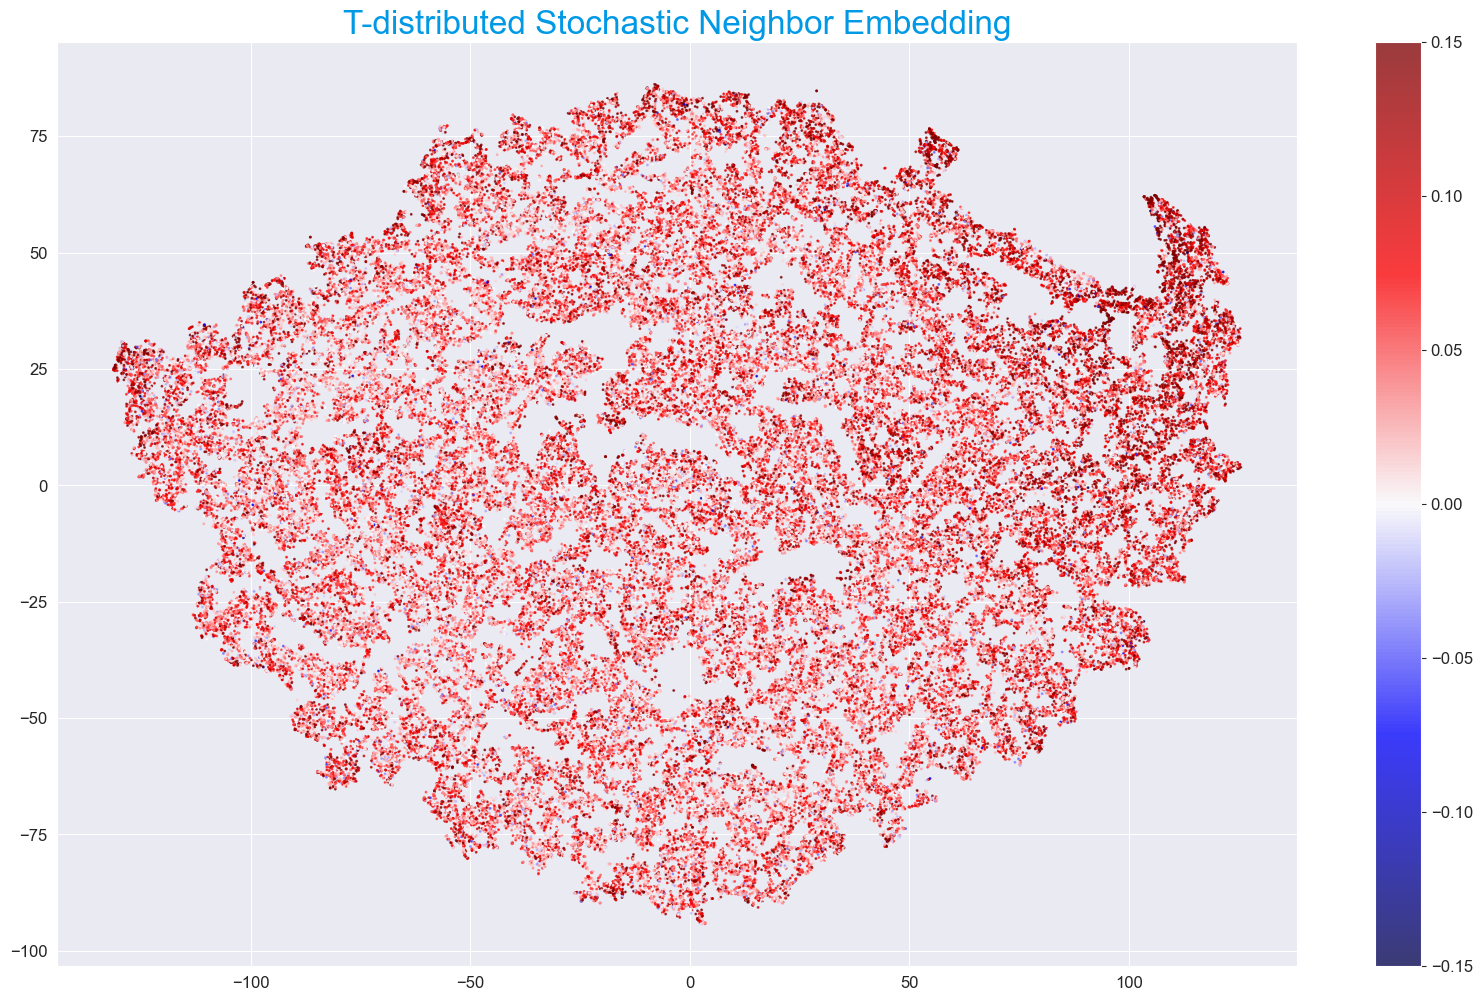

In [101]:
f, ax = plt.subplots(figsize=(20, 12))
points = ax.scatter(x=S_t_sne[:, 0], y=S_t_sne[:, 1], c=df_recent[max_target], alpha=0.75, s=1, cmap="seismic", vmin=-0.15, 
                    vmax=0.15)
ax.set_title("T-distributed Stochastic Neighbor Embedding", fontsize=24);

f.colorbar(points);
